## **CONTENT**
* **1. Numpy Implementation + Quadratic Cost**
* **2. Numpy Implementation + Binary Cross Entropy Cost**
* **3. Softmax Activation**
* **4. Regularization**
* **5. Bias/Weight Initialization**
* **6. Hyperparameters**
* **7. Other Performance-Enhancing Techniques**
* **8. Other Activations (Hyperbolic Tangent & Rectifier Linear)**
* **9. Universality of Neural Network**
* **10. Deep Learning**

# Basic Implementation (Numpy + Quadratic Cost)

In [70]:
import numpy as np
import random

In [71]:
from IPython.display import Image, display

In [72]:
# NB: RUN ONLY ONCE!!
datapath = "/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/DATA/neural-networks-and-deep-learning-master/"
import sys
sys.path.append(datapath)

In [73]:
class NNNumpy:
    
    def __init__(self, sizes): 
        # ARGS
        #  sizes: [2,3,1] = 2 neurons in input, 3 in hidden, 1 in output.
        self.numLayers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y,1) for y in sizes[1:]] 
            # generate bias=1 for each layer. the first layer (input) doesn't need bias.
            # e.g. each neuron in hidden gets a bias=1. 
            #  because each neuron processes a \sum_dot(W,t).
        self.weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]
            # the dimensions of the weight-matrix between layer s and t is t*s
            # e.g. [2,3,1] architecture, input(2) -- W1 -- hidden(3), W1 = 3x2.
            #  W1_jk is the connection between the kth in input and jth in hidden.
            # this is for the convenience of computation:
            #  input   W1   hidden
            #  2x1     3x2  3x1
            #  dim_hidden(3x1) = W1*input(3x2 * 2x1 = 3x1).
            #  otherwise, we would have to write (input^T*W1)^T.
        # correspondences:
        #  input    W1    hidden   W2    output
        #           ^       ^      ^       ^
        #           |       |      |       |
        #           |   biases[0]  |    biases[1]
        #           |              |
        #       weights[0]      weights[1]
     
    def forward_propagation(self, a):
        # ARGS
        #  a: input vector.
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
        # flow of propagation (e.g. [2,3,1] architecture):
        # 
        #  output = sigmoid(W2*sigmoid(W1*a + b1) + b2)
        # 
        #    b1(3x1)    W1(3x2)    a(2x1)
        #      W1*a + b1 = sigmoid((3x2 * 2x1) + 3x1) = 3x1 => a(3x1)
        #    b2(1x1)    W2(1x3)    a(3x1)
        #      W2*a + b2 = sigmoid((1x3 * 3x1) + 1x1) = 1x1 => a(1x1)
        #    a => output
    
    def SGD(self, X_train, epochs, batchSize, lr, test=None):
        # ARGS
        #  X_train: [(x1,y1),(x2,y2),..]
        #  epochs: the number of cycles.
        #  batchSize: the size stochastic gradient-sampling.
        #  lr: learning rate.
        #  test: if provided, evaluate learning against it after each epoch.
        # DEPS
        #  self.update_batch [single step of gradient descent]
        #  self.evaluate
        if test: nTest = len(test)
        n = len(X_train)
        for j in xrange(epochs):
            # xrange(start,end,[step]): same as range(), 
            # except it generates an immutable sequence,
            #  same amount of memory use no matter the size range represents.
            random.shuffle(X_train)
            batches = [ X_train[k:k+batchSize] for k in xrange(0, n, batchSize) ]
                # partitioning data into batches, each is of _batchSize_ size.
            for batch in batches:
                self.update_batch(batch, lr)
            if test:
                print "Epoch {0}: {1} / {2}".format(j, self.evaluate(test), nTest)
            else: 
                print "Epoch {0} complete".format(j)
    
    def update_batch(self, batch, lr):
        # ARGS
        #  batch: [(x1,y1),(x2,y2),..] sample from X_train.
        #  lr: passed from SGD.
        # DEPS
        #  self.back_propagation
        bGrads = [ np.zeros(b.shape) for b in self.biases ]
        wGrads = [ np.zeros(w.shape) for w in self.weights ]
            # create a zero list for each bias/weight matrix.
        for x, y in batch:
            # backprop data point by data point.
            bGradDeltas, wGradDeltas = self.back_propagation(x, y)
                # proper bias/weight gradient deltas are computed by backprop process.
            bGrads = [bGrad+bGradDelta for bGrad,bGradDelta in zip(bGrads,bGradDeltas)]
            wGrads = [wGrad+wGradDelta for wGrad,wGradDelta in zip(wGrads,wGradDeltas)]
                # put computed gradient deltas in zero containers.
        self.biases = [ b-(lr/len(batch))*bGrad for b,bGrad in zip(self.biases,bGrads) ]
        self.weights = [ w-(lr/len(batch))*wGrad for w,wGrad in zip(self.weights,wGrads) ]
            # update biases/weights after the whole batch is done.
            #  b_l <- b_l - lr/len(smp) * \sum dC_smp/db_l
            #  w_k <- w_k - lr/len(smp) * \sum dC_smp/dw_k
            #             ^                ^
            #             |                |
            #   computed after loop   computed in loop
    
    def back_propagation(self, x, y): # TODO: output = sigmoid(W2*sigmoid(W1*a + b1) + b2) 
        # ARGS
        #  x, y: a pair of data points.
        # DEPS
        #  self.cost_derivative
        #  sigmoid, sigmoid_prime
        bGrads = [ np.zeros(b.shape) for b in self.biases ]
        wGrads = [ np.zeros(w.shape) for w in self.weights ]
            # create a zero list for each bias/weight matrix.
        
        activation = x                                                      # forward step
        activations = [x] # list for sigmoid(W*a + b)                            #
        zs = [] # list for (W*a + b)                                             #
        for b,w in zip(self.biases, self.weights):                               #
            z = np.dot(w, activation) + b                                        #
            zs.append(z)                                                         #
            activation = sigmoid(z)                                              #
            activations.append(activation)                                       #
                                                                            # backward step
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) #
            # BP1: compute error delta^L at the output layer                     #
            #                                                                    #
            # delta_j^L = dC/dz_j^L                                              #
            #           = dC/da_j^L * da_j^L/dz_j^L                              #
            #                ^               ^                                   #
            #                |               |                                   #
            #   pace at which cost       pace at which                           #
            #   changes wrt. activation  activation changes                      #
            #                            wrt. pre-sigmoid output                 #
            #                                                                    #  
            # NB: the '*' multiplication here is Hadamard.                       #
            #                                                                    #
        bGrads[-1] = delta                                                       #
            # BP3: compute the rate of change of the cost wrt bias.              #
            #                                                                    #
            # dC/db_l = delta^l                                                  #
            #                                                                    #
        wGrads[-1] = np.dot(delta, activations[-2].transpose())                  #
        for l in xrange(2, self.numLayers):                                      #
            z = zs[-l]                                                           #
            sp = sigmoid_prime(z)                                                #
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp           #
            # BP2: compute error delta^l at a non-output layer                   #
            #                                                                    #
            # delta^l = ( (w^l+1)^T %*% delta^l+1 ) * sigma'(z^l) (i.e. dC/da_l) #
            #                        ^                    ^                      #
            #                        |                    |                      #
            #            error propagated back       pace at which               #
            #            from layer l+1              activation (at layer l)     #
            #                                        changes wrt. z^l            #
            #                                                                    #
            # e.g. 2(l=1) -> 3(l=2) -> 1(l=3) architecture, at layer l=2         # 
            #      the number of local neurons = 3                               #
            #      the size of the matrix between l=2 and l=3 is 1x3             #
            #      ( (w^l+1)^T %*% delta^l+1 ) = ( (1x3)^T %*% 1x1 ) => 3x1      #
            #      sigma'(z^l) = 3x1                                             #
            #                                                                    #
            bGrads[-l] = delta                                                   # 
            wGrads[-l] = np.dot(delta, activations[-l-1].transpose())            #
            # BP4: compute the rate of change of the cost wrt. weight            #
            #                                                                    #
            # dC/dw_jk^l = a_k^l-1 %*% delta_j^l                                 #
            #                                                                    #
            # e.g. 2(l=1) -> 3(l=2) -> 1(l=3) architecture, at layer l=3         #
            #      activation at layer l-1 (i.e. l=2) is 3x1                     #
            #      error delta^l is 1x1                                          #
            #      delta^l %*% a^l-1 = 1x1 %*% (3x1)^T => 1x3 (dim of w^l)       #
            #                                                                    #
        return (bGrads, wGrads)                                                  #
            # overall updates                                                    #
            # e.g. 2(l=1) -> 3(l=2) -> 1(l=3) architecture, at layer l=2         #
            #                                                                    #
            #       l=1               l=2                l=3                     #
            #     #######           ########          ########                   #
            #     #input#   w=2-----#hidden#    w=3---#output#                   #
            #     #######           ########     ^    ########                   #
            #                       b=1  delta^2 |    b=2  delta^3               #
            #                       ^      ^     |    ^      ^                   #
            #                       |      |     |    |      |                   #
            #                       BP3   BP2   BP4  BP3    BP1                  #
            #                                                                    #
            # NB: for BPs, see figure attached after this cell.                  #
    
    def evaluate(self, test):
        # ARGS
        #  test: testset, for which return the number of corrected predicted.
        # DEPS
        #  self.forward_propagation
        testResults = [ (np.argmax(self.forward_propagation(x)), y) for (x, y) in test ]
        return sum(int(x==y) for (x,y) in testResults)
    
    def cost_derivative(self, outputActivations, y):
        # ARGS
        #  outputActivations: output.
        #  y: correct.
        return (outputActivations-y)
            # dC/da (note: a = output)
            # why a - y?
            #  C = 1/2 \sum_j (y_j - a_j)^2
            #  dC/da = (a_j - y_j)

BACKPROP EQUATIONS:


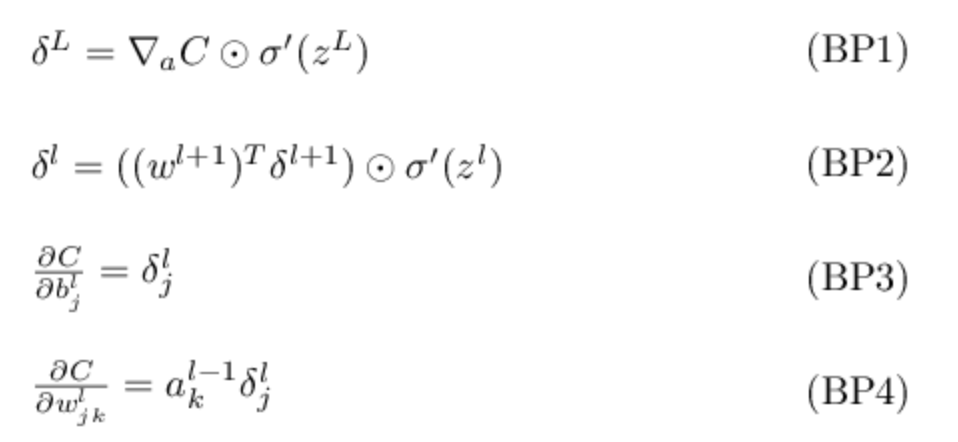

BACKPROP ALGORITHM:


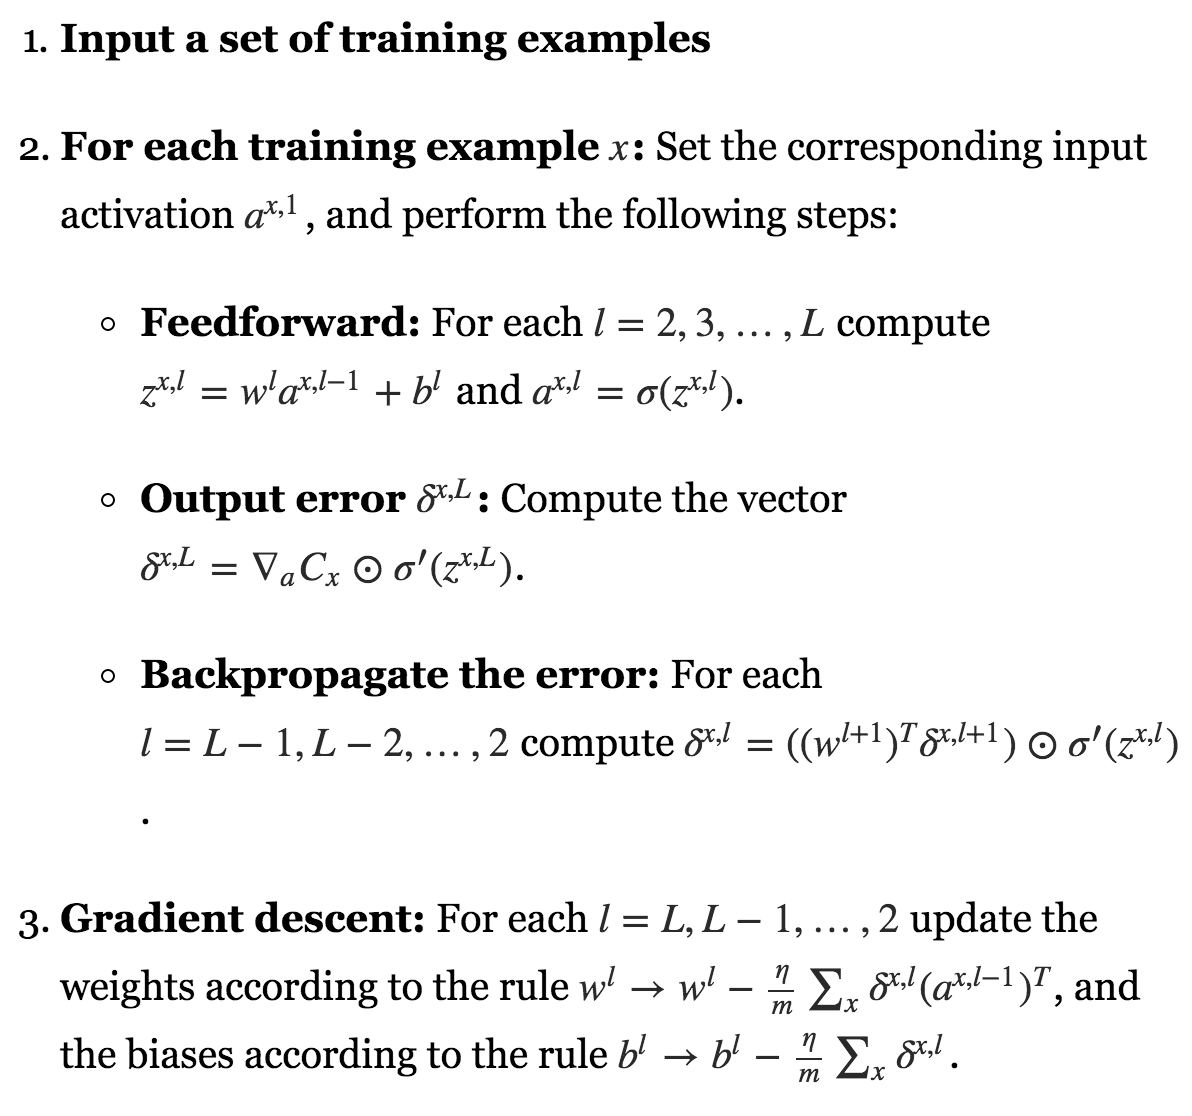

In [74]:
# BPS
print "BACKPROP EQUATIONS:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/backprop_equations.png", width="35%"))
print "BACKPROP ALGORITHM:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/backprop_algorithm.png", width="40%"))

In [75]:
def sigmoid(z):
    return 1.0 / (1.0+np.exp(-z)) # np.exp() applies elementwise if z is a vector.
def sigmoid_prime(z): # derivative of sigmoid.
    return sigmoid(z) * (1-sigmoid(z))

### TEST SECTION

In [62]:
np.random.randn(2,1)

array([[-0.21870283],
       [-1.87428031]])

In [63]:
sizes = [2,3,1]
sizes[:-1]

[2, 3]

In [64]:
biases = [np.random.randn(y,1) for y in sizes[1:]]
weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]

In [69]:
for b,w in zip(biases,weights):
    print "##"
    print np.array(b)
    print np.array(w)
    print "##"

##
[[ 0.47841193]
 [ 0.62306404]
 [-1.99710103]]
[[-1.52568539  1.51568236]
 [-0.52236253  0.02812204]
 [-0.49932354  0.33427414]]
##
##
[[ 0.07765981]]
[[ 0.6736189   0.47265584  0.0171147 ]]
##


In [66]:
biases[1]
weights[1]

array([[ 0.6736189 ,  0.47265584,  0.0171147 ]])

In [67]:
weights[-1].transpose()

array([[ 0.6736189 ],
       [ 0.47265584],
       [ 0.0171147 ]])

In [68]:
np.dot(weights[-1].transpose(), np.array([1,1,1]).reshape(1,3))

array([[ 0.6736189 ,  0.6736189 ,  0.6736189 ],
       [ 0.47265584,  0.47265584,  0.47265584],
       [ 0.0171147 ,  0.0171147 ,  0.0171147 ]])

In [76]:
%%time
import os
os.chdir("/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/DATA/neural-networks-and-deep-learning-master/src")
import mnist_loader # works when under '~/src' path.
X_train, X_dev, X_test = mnist_loader.load_data_wrapper()
fnn = NNNumpy([784,30,10])
fnn.SGD(X_train,30,10,3.0,test=X_test)

Epoch 0: 9081 / 10000
Epoch 1: 9219 / 10000
Epoch 2: 9282 / 10000
Epoch 3: 9346 / 10000
Epoch 4: 9362 / 10000
Epoch 5: 9429 / 10000
Epoch 6: 9383 / 10000
Epoch 7: 9422 / 10000
Epoch 8: 9428 / 10000
Epoch 9: 9427 / 10000
Epoch 10: 9439 / 10000
Epoch 11: 9446 / 10000
Epoch 12: 9466 / 10000
Epoch 13: 9433 / 10000
Epoch 14: 9441 / 10000
Epoch 15: 9451 / 10000
Epoch 16: 9477 / 10000
Epoch 17: 9476 / 10000
Epoch 18: 9478 / 10000
Epoch 19: 9496 / 10000
Epoch 20: 9482 / 10000
Epoch 21: 9480 / 10000
Epoch 22: 9470 / 10000
Epoch 23: 9483 / 10000
Epoch 24: 9461 / 10000
Epoch 25: 9492 / 10000
Epoch 26: 9484 / 10000
Epoch 27: 9489 / 10000
Epoch 28: 9493 / 10000
Epoch 29: 9486 / 10000
CPU times: user 3min 53s, sys: 4.87 s, total: 3min 58s
Wall time: 3min 58s


# Cost Function

### 1. Updating a single neuron (cost = Sigmoid)

UPDATING SINGLE NEURON:


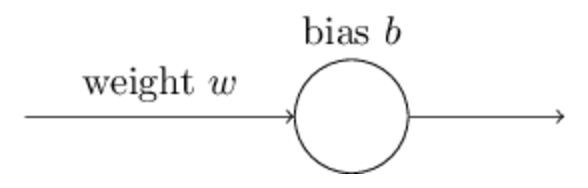

GRADIENT SINGLE NEURON:


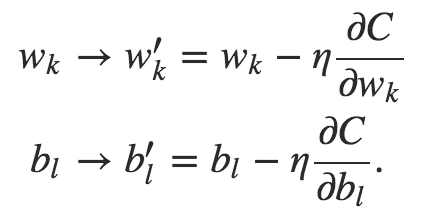

QUADRATIC COST:


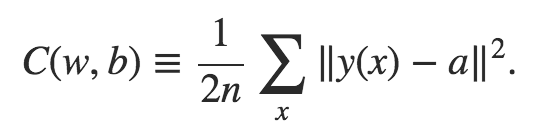

In [57]:
# SCHEME
print "UPDATING SINGLE NEURON:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/updating_single_neuron.png", width="25%"))
print "GRADIENT SINGLE NEURON:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/gradient_single_neuron.png", width="15%"))
print "QUADRATIC COST (n = number of training inputs):"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/cost_single_neuron.png", width="20%"))

In [92]:
# GOAL: INPUT 1, OUTPUT 0
x, y = 1, 0

# INITIALIZE
b, w, lr = .9, .6, .15

# QUADRATIC COST
def cost(b, w):
    z = fwd(x)
    a = sigmoid(z)
    return (1./2) * (y-a)**2

# FORWARD PROP
def fwd(x): 
    # compute z.
    return w*x + b

# GRADIENTS
#  bGrad = dC/da * da/dz * dz/db
#        = (a-y) * a(1-a) * 1
#  wGrad = dC/da * da/dz * dz/dw
#        = (a-y) * a(1-a) * x

# BACKWARD PROP
def bwd(x, y):
    # compute bGrad, wGrad.
    z = fwd(x)
    a = sigmoid(z)
    bGrad = (a-y) * a*(1-a) * 1
    wGrad = (a-y) * a*(1-a) * x
    return (bGrad, wGrad)

# UPDATE
#  b = b - lr*bGrad
#  w = w - lr*wGrad
def update(b, w):
    bGrad, wGrad = bwd(x, y)
    bPrime = b - lr*bGrad
    wPrime = w - lr*wGrad
    return (bPrime, wPrime)

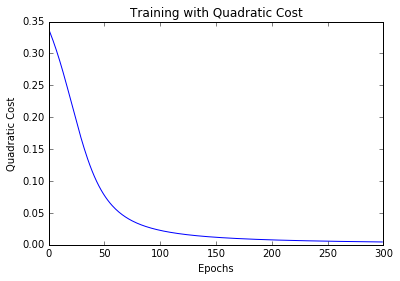

In [93]:
# SINGLE UPDATE
epochs = 300
epochTrack = []
costTrack = []
epoch = 0
for i in range(1,epochs):
    costTrack.append(cost(b, w))
    epochTrack.append(i)
    b, w = update(b, w)

# EPOCH-COST
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epochTrack, costTrack)
plt.xlabel("Epochs")
plt.ylabel("Quadratic Cost")
plt.title("Training with Quadratic Cost")
plt.show()

In [94]:
# AFTER TRAINING...
y_hat = fwd(x)
print "Predicted: %.2f | True: %.2f " % (sigmoid(y_hat), y)

Predicted: 0.09 | True: 0.00 


### 2. Updating a single neuron (cost = Binary Cross Entropy)

UPDATING SINGLE NEURON:


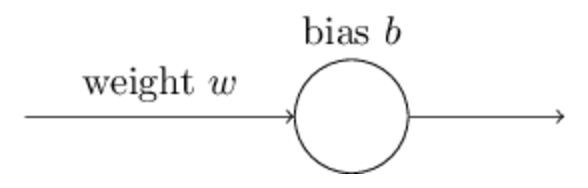

GRADIENT SINGLE NEURON (BINARY CROSSENT):


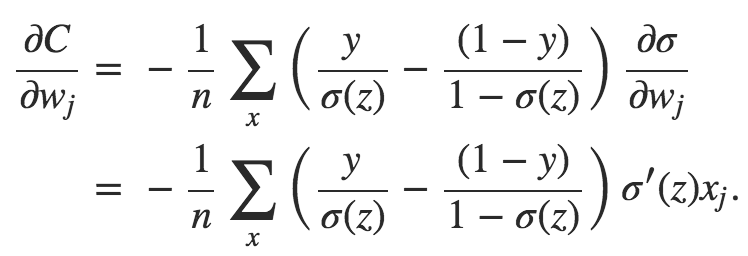

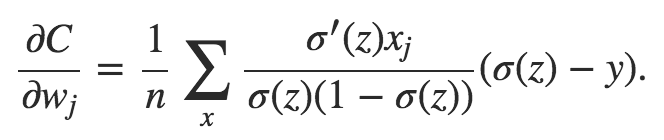

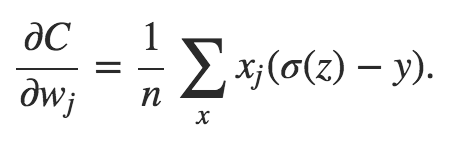

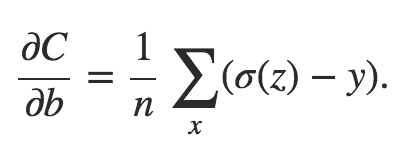

BINARY CROSSENT COST (n = number of training inputs):


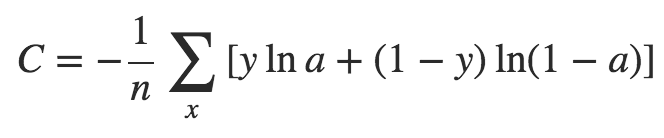

In [89]:
# SCHEME
print "UPDATING SINGLE NEURON:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/updating_single_neuron.png", width="25%"))
print "GRADIENT SINGLE NEURON (BINARY CROSSENT):"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/gradient_w_1_binary_crossentropy.png", width="25%"))
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/gradient_w_2_binary_crossentropy.png", width="25%"))
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/gradient_w_3_binary_crossentropy.png", width="20%"))
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/gradient_b_binary_crossentropy.png", width="18%"))
print "BINARY CROSSENT COST (n = number of training inputs):"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/cost_binary_crossentropy.png", width="30%"))

In [122]:
# GOAL: INPUT 1, OUTPUT 0
x1, y1 = 0, 0
x2, y2 = 1, 1

# INITIALIZE
b, w, lr = .9, .6, .15

# BINARY CROSSENT COST
def cost(b, w, x, y):
    z = fwd(x)
    a = sigmoid(z)
    return -(y*np.log(a) + (1-y)*np.log(1-a))

# FORWARD PROP
def fwd(x): 
    # compute z.
    return w*x + b

# GRADIENTS
#  bGrad = dC/da * da/dz * dz/db
#        = - [ (y/a - (1-y)/(1-a)) * a(1-a) * 1 ]
#        = (a-y) * 1
#  wGrad = dC/da * da/dz * dz/dw
#        = - [ (y/a - (1-y)/(1-a)) * a(1-a) * x ]
#        = (a-y) * x

# NB: Why is BINARY CROSSENT learning at a faster rate??
#  the a*(1-a) (sigmoid) term we see in the gradient of
#  QUADRATIC COST **GOES FLAT TOWARDS both 0 and 1 ends!
#  BINARY CROSSENT COST, on the other hand, does not have
#  this slow-down term. Its change is directly controled
#  by the input.

# BACKWARD PROP
def bwd(x, y):
    # compute bGrad, wGrad.
    z = fwd(x)
    a = sigmoid(z)
    bGrad = a-y
    wGrad = (a-y) * x
    return (bGrad, wGrad)

# UPDATE
#  b = b - lr*bGrad
#  w = w - lr*wGrad
def update(b, w, x, y):
    bGrad, wGrad = bwd(x, y)
    bPrime = b - lr*bGrad
    wPrime = w - lr*wGrad
    return (bPrime, wPrime)

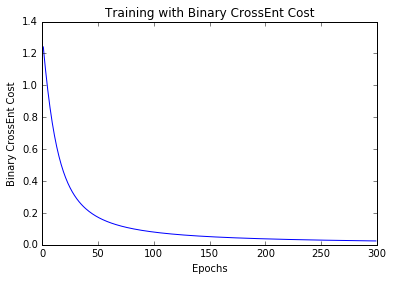

In [123]:
# SINGLE UPDATE (x1, y1)
epochs = 300
epochTrack = []
costTrack = []
epoch = 0
for i in range(1,epochs):
    costTrack.append(cost(b, w, x1, y1))
    epochTrack.append(i)
    b, w = update(b, w, x1, y1)
    
# EPOCH-COST
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epochTrack, costTrack)
plt.xlabel("Epochs")
plt.ylabel("Binary CrossEnt Cost")
plt.title("Training with Binary CrossEnt Cost")
plt.show()

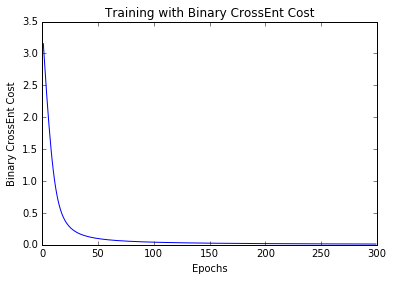

In [124]:
# SINGLE UPDATE (x2, y2)
epochs = 300
epochTrack = []
costTrack = []
epoch = 0
for i in range(1,epochs):
    costTrack.append(cost(b, w, x2, y2))
    epochTrack.append(i)
    b, w = update(b, w, x2, y2)
    
# EPOCH-COST
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epochTrack, costTrack)
plt.xlabel("Epochs")
plt.ylabel("Binary CrossEnt Cost")
plt.title("Training with Binary CrossEnt Cost")
plt.show()

In [125]:
# AFTER TRAINING...
y1_hat = fwd(x1)
y2_hat = fwd(x2)
print "Predicted: %.2f | True: %.2f " % (sigmoid(y1_hat), y1)
print "Predicted: %.2f | True: %.2f " % (sigmoid(y2_hat), y2)

Predicted: 0.51 | True: 0.00 
Predicted: 0.99 | True: 1.00 


### 3. Revised NNNumpy (Binary CrossEnt Cost)
* NB: Regularization & I/O in next section.

In [17]:
import numpy as np
import sys, json

In [107]:
class QuadraticCost:
    
    @staticmethod
    def fnn(a, y): return 0.5*np.linalg.norm(a-y)**2
    
    @staticmethod
    def delta(z, a, y): return (a-y) * sigmoid_prime(z)
    
class CrossEntropyCost:
    
    @staticmethod
    def fnn(a, y): return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
        # np.nan_to_num handles well log of numbers close to 0.
    
    @staticmethod
    def delta(z, a, y): return (a-y)
    

In [144]:
class NNNumpy:
    
    def __init__(self, sizes, cost=CrossEntropyCost): 
        self.numLayers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
    
    def default_weight_initializer(self):
        # biases initialization: N(0, 1)
        # weights initialization: N(0, 1/sqrt(# of weights connecting to the same neuron))     
        self.biases = [np.random.randn(y,1) for y in self.sizes[1:]] 
        self.weights = [np.random.randn(y,x)/np.sqrt(x) for x,y in zip(self.sizes[:-1],self.sizes[1:])]
        
    def large_weight_initializer(self):
        # biases initialization: N(0, 1)
        # weights initialization: N(0, 1)
        self.biases = [np.random.randn(y,1) for y in self.sizes[1:]] 
        self.weights = [np.random.randn(y,x) for x,y in zip(self.sizes[:-1],self.sizes[1:])]
     
    def forward_propagation(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    def SGD(self, X_train, epochs, batchSize, lr, 
            lmd=0.0, evaluationData=None, 
            monitorEvaluationCost=False, monitorEvaluationAccuracy=False,
            monitorTrainingCost=False, monitorTrainingAccuracy=False):
        # lmd: regularization parameter.
        # monitor*: 4 lists of evaluation/training cost/accuracy tracks (elem=batch).
        if evaluationData: nData = len(evaluationData)
        n = len(X_train)
        evaluationCost, evaluationAccuracy = [], []
        trainingCost, trainingAccuracy = [], []
        for j in xrange(epochs):
            random.shuffle(X_train)
            batches = [ X_train[k:k+batchSize] for k in xrange(0, n, batchSize) ]
            for batch in batches:
                self.update_batch(batch, lr, lmd, len(X_train))
            print "Epoch %s training complete" % j
            if monitorTrainingCost:
                cost = self.total_cost(X_train, lmd)
                trainingCost.append(cost)
                print "Cost on training data: {}".format(cost)
            if monitorTrainingAccuracy:
                accuracy = self.accuracy(X_train, convert=True)
                trainingAccuracy.append(accuracy)
                print "Accuracy on training data: {} / {}".format(accuracy, n)
            if monitorEvaluationCost:
                cost = self.total_cost(evaluationData, lmd, convert=True)
                evaluationCost.append(cost)
                print "Cost on evaluation data: {}".format(cost)
            if monitorEvaluationAccuracy:
                accuracy = self.accuracy(evaluationData)
                evaluationAccuracy.append(accuracy)
                print "Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluationData),nData)
            print
        return evaluationCost, evaluationAccuracy, trainingCost, trainingAccuracy
    
    def update_batch(self, batch, lr, lmd, n):
        # lmd: regularization term.
        # n: total size of training dataset.
        bGrads = [ np.zeros(b.shape) for b in self.biases ]
        wGrads = [ np.zeros(w.shape) for w in self.weights ]
        for x, y in batch:
            # backprop data point by data point.
            bGradDeltas, wGradDeltas = self.back_propagation(x, y)
            bGrads = [bGrad+bGradDelta for bGrad,bGradDelta in zip(bGrads,bGradDeltas)]
            wGrads = [wGrad+wGradDelta for wGrad,wGradDelta in zip(wGrads,wGradDeltas)]
        self.biases = [ b-(lr/len(batch))*bGrad for b,bGrad in zip(self.biases,bGrads) ]
        self.weights = [ (1-lr*(lmd/n))*w - (lr/len(batch))*wGrad 
                         for w,wGrad in zip(self.weights,wGrads) ]
            # updating with L2 regularization (see below).
            # L1 version:
            #  self.weights = [ w - lr*(lmd/n)*sgn(w) - (lr/len(batch))*wGrad
            #                   for w,wGrad in zip(self.weights,wGrads) ]
            
    
    def back_propagation(self, x, y): 
        bGrads = [ np.zeros(b.shape) for b in self.biases ]
        wGrads = [ np.zeros(w.shape) for w in self.weights ]
        activation = x                                                      # forward step
        activations = [x] # list for sigmoid(W*a + b)                            #
        zs = [] # list for (W*a + b)                                             #
        for b,w in zip(self.biases, self.weights):                               #
            z = np.dot(w, activation) + b                                        #
            zs.append(z)                                                         #
            activation = sigmoid(z)                                              #
            activations.append(activation)                                       #
                                                                            # backward step
        delta = (self.cost).delta(zs[-1], activations[-1], y)                    #
            # delta(z, a, y)                                                     #
            #  - Quadratic Cost: (a-y) * sigmoid_prime(z)                        #
            #  - CrossEntropy Cost: (a-y)                                        #
        bGrads[-1] = delta                                                       #
        wGrads[-1] = np.dot(delta, activations[-2].transpose())                  #
        for l in xrange(2, self.numLayers):                                      #
            z = zs[-l]                                                           #
            sp = sigmoid_prime(z)                                                #
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp           #
            bGrads[-l] = delta                                                   # 
            wGrads[-l] = np.dot(delta, activations[-l-1].transpose())            #
        return (bGrads, wGrads)                                                  
    
    def accuracy(self, data, convert=False):
        # FUNC: returns the number of inputs in _data_ for which fnn outputs are correct.
        # convert: True if data=train; False if data=dev/test.
        #                      ^                    ^
        #                      |                    |
        #             interested in cost     intested in accuracy
        if convert: 
            results = [(np.argmax(self.forward_propagation(x)), np.argmax(y))
                       for (x,y) in data]
        else:
            results = [(np.argmax(self.forward_propagation(x)), y)
                       for (x,y) in data]
        return sum(int(x==y) for (x,y) in results)
    
    def total_cost(self, data, lmd, convert=False):
        # convert: True if data=train; False if data=dev/test.
        cost = 0.0
        for x,y in data:
            a = self.forward_propagation(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a,y) / len(data)
            # fn(a, y)
            #  - Quadratic Cost: 0.5*np.linalg.norm(a-y)**2
            #  - CrossEntropy Cost: np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
        cost += 0.5 * (lmd/len(data)) * sum(np.linalg.norm(w)**2 for w in self.weights)
            # compute cost with L2 regularization.
            # L1 version:
            #  cost += (lmd/len(data)) * sum(np.linalg.norm(abs(w)) for w in self.weights)
            # np.linalg.norm computes the normalized magnitude of a vector.
            # e.g. 
            #  np.linalg.norm([1,2,3,4]) produces 5.4772255750516612, whereas
            #  np.dot([1,2,3,4],[1,2,3,4]) produces 30.
        return cost
    
    def save(self, filename):
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()
        # __name__ (TODO: MORE EXP):
        # ---------------------TEST_CODE-------------------
        # class name:
        #    def __init__(self):
        #        return
        # class test:
        #    def __init__(self, var = name):
        #        self.var = var
        # test = test()
        # store = {"var": str(test.var.__name__)}
        # getattr(sys.modules[__name__], store["var"])
        # --------------------------------------------------
        # OUTPUT: <class __main__.name at 0x119ec53f8>


In [58]:
def sigmoid(z):
    return 1.0 / (1.0+np.exp(-z)) # np.exp() applies elementwise if z is a vector.
def sigmoid_prime(z): # derivative of sigmoid.
    return sigmoid(z) * (1-sigmoid(z))

In [143]:
def load(filename):
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    fnn = NNNumpy(data["sizes"], cost=cost)
    fnn.biases = [np.array(b) for b in data["biases"]]
    fnn.weights = [np.array(w) for w in data["weights"]]
    return fnn

def vectorized_result(j):
    e = np.zeros((10,1))
    e[j] = 1.0
    return e

In [ ]:
# FOR L1 REG
def sgn(x): return -x

### TEST AREA

In [60]:
import os
os.chdir("/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/DATA/neural-networks-and-deep-learning-master/src")
import mnist_loader # works when under '~/src' path.
X_train, X_dev, X_test = mnist_loader.load_data_wrapper()

In [61]:
%%time
fnn = NNNumpy([784,30,10], cost=CrossEntropyCost)
fnn.large_weight_initializer()
fnn.SGD(X_train, 30, 10, .5, evaluationData=X_test, monitorEvaluationAccuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9145 / 10000

Epoch 1 training complete
Accuracy on evaluation data: 9324 / 10000

Epoch 2 training complete
Accuracy on evaluation data: 9359 / 10000

Epoch 3 training complete
Accuracy on evaluation data: 9380 / 10000

Epoch 4 training complete
Accuracy on evaluation data: 9426 / 10000

Epoch 5 training complete
Accuracy on evaluation data: 9443 / 10000

Epoch 6 training complete
Accuracy on evaluation data: 9431 / 10000

Epoch 7 training complete
Accuracy on evaluation data: 9445 / 10000

Epoch 8 training complete
Accuracy on evaluation data: 9471 / 10000

Epoch 9 training complete
Accuracy on evaluation data: 9491 / 10000

Epoch 10 training complete
Accuracy on evaluation data: 9503 / 10000

Epoch 11 training complete
Accuracy on evaluation data: 9460 / 10000

Epoch 12 training complete
Accuracy on evaluation data: 9515 / 10000

Epoch 13 training complete
Accuracy on evaluation data: 9517 / 10000

Epoch 14 training complete
Acc

# Softmax

### A. Properties

* Output Function:
$ z_j^L = \sum_k w_{jk}^L a_k^{L-1} + b_j^L $
* Output Softmax Activation:
$ a_j^L = \frac{e^{z_j^L}}{\sum_k e^{z_k^L}} $
* Softmax property:
$ \sum_j a_j^L = \frac{\sum_j e^{z_j^L}}{\sum_k e^{z_k^L}} = 1 $


* Why $e^z$ instead of simply $z$? Because exponential function guarantees positive for probability interpretation.
* Note that Sigmoid Activation doesn't have this probability interpretation.

### B. Related Cost Function: Log-Likelihood Cost

* Cost: 
$ C = -ln a_y^L $
* Gradient:
    * $ \frac{\partial C}{\partial b_j^L} = a_j^L - y_j $
    * $ \frac{\partial C}{\partial w_{jk}^{L-1}} = a_k^{L-1}(a_j^L - y_j) $


* As in the case of Cross Entropy Cost, we do not experience learning slowdown issue with Log-Likelihood Cost.

# Regularization

**Why Reguliarzation?**

* Raison D'$\hat{e}$tre: 
    * Regularized function prefers small weights.
    * Large weights are only allowed when they considerably improve C.
* Regularization term $\lambda$:
When $\lambda$ is large, small weights is preferred; otherwise, minimizing C is perferred.

### A. L2 Regularization

**a. Basic Properties**

* Regularized cost: $ C_{reg} = C + \frac{\lambda}{2n} \sum_w w^2 $

**b. Gradient**

* Bias:
$ \frac{\partial C_{reg}}{\partial b} = \frac{\partial C}{\partial b} $
* Weight:
$ \frac{\partial C_{reg}}{\partial w} = \frac{\partial C}{\partial w} + \frac{\lambda}{n} w $

**c. Update**

* Bias:
$ b = b - \eta \frac{\partial C}{\partial b} $
* Weight:
$ w = w - \eta \frac{\partial C}{\partial w} - \frac{\eta\lambda}{n} w = (1 - \frac{\eta\lambda}{n})w - \eta \frac{\partial C}{\partial w} $
* NB: In m-batch update $ \eta \frac{\partial C}{\partial w} $ becomes $ \frac{\eta}{m} \sum_x \frac{\partial C_x}{\partial w} $)

### B. L1 Regularization

**a. Basic Properties**

* Regularized cost: 
$ C_{reg} = C + \frac{\lambda}{n} \sum_w |w| $

**b. Gradient**

* Bias:
$ \frac{\partial C_{reg}}{\partial b} = \frac{\partial C}{\partial b} $
* Weight:
$ \frac{\partial C_{reg}}{\partial w} = \frac{\partial C}{\partial w} + \frac{\lambda}{n} sgn(w) $ 
* $sgn(x)$ Function:
$ sgn(x) = -x $

**c. Update**

* Bias:
$ b = b - \eta \frac{\partial C}{\partial b} $
* Weight:
$ w = w - \eta \frac{\partial C}{\partial w} - \frac{\eta\lambda}{n} sgn(w) $
* NB: In m-batch update $ \eta \frac{\partial C}{\partial w} $ becomes $ \frac{\eta}{m} \sum_x \frac{\partial C_x}{\partial w} $)

### C. Comparing L1 & L2

* L1 shrinks $w$ towards 0 by a constant rate; L2 by an amount proportional to $w$. Therefore, when $w$ is large, L1 shrinks it slower than L2 does.
* L1 regularization tends to concentrate the weight of the network in a relatively small number of high-importance connections, while other weights are driven towards 0. L2, on the other hand, takes a more "egalitarian" approach.
* L1 can shrink $w$ to 0, at which point, by the fact that $sgn(0) = 0$, the update stops. (Q: what about $\frac{\partial C}{\partial w}$ term, where partial derivative is not defined when $w=0$?)

### D. Dropout Regularization

**a. Technique**

* Randomly "ghost out" a fraction of neurons in hidden layers.

**b. Rationale**

* In a standard NN training, the output is decided by neurons voting. In a dropout-regularized NN, however, we are basically training different NNs and let them take vote. In so doing, we expect the chance overfitting to be reduced.

# Weight Initialization

* Problems with Initializing with $N(0, 1)$ (i.e. vanilla Gaussian): High Standard Deviation causes many neurons to be saturated and thus learn at a slow pace with SGD.
* Solution: Initializing with $N(0, \frac{1}{\sqrt{n}})$.

* NB: Initializing with $0$ is fine too.
* NB: The learning output (i.e. accuracy) will be similar to $N(0, 1)$ initialization, however the learning will be much faster. Note that, with the same number of epochs, $N(0, \frac{1}{\sqrt{n}})$ initialization tends to produce better results.

### DEMO: $N(0, 1)$ has a much wider distribution, which causes $|z|$ to end up large (i.e. close to either 0 or 1).

In [84]:
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
vanillaGaussian = np.random.randn(1000)
smallGaussian = np.random.randn(1000)/np.sqrt(50000) # assuming we have 50,000 input data points.

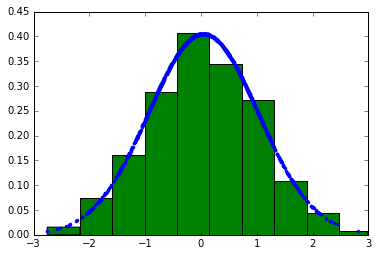

In [105]:
fit = stats.norm.pdf(vanillaGaussian, np.mean(vanillaGaussian), np.std(vanillaGaussian))
plt.plot(vanillaGaussian, fit, '.')
plt.xlim(-3,3)
plt.ylim(0,.45)
plt.hist(vanillaGaussian, normed=True)
plt.show()

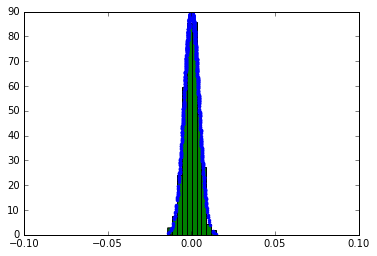

In [106]:
fit = stats.norm.pdf(smallGaussian, np.mean(smallGaussian), np.std(smallGaussian))
plt.plot(smallGaussian, fit, '.')
plt.xlim(-.1,.1)
plt.hist(smallGaussian, normed=True)
plt.show()

# Hyperparameters

*TODO: DEMO GRIDSEARCH

# Other Techniques

### A. Hessian Cost

**a. Update (e.g. weight):**
* $ w = w - H^{-1}\nabla C $ instead of $ w = w - \eta\nabla C $.

**b. Pros & Cons**
* Pro: Taking into consideration second derivatives to increase the speed of updating. Specifically, update with higher added-speed on stiff slope, lower add-speed on flatter slope. 
* Con: Difficult to implement due to the size of the Hessian matrix -- computing its inverse will be computationally very costly.

### B. Momentum

**a. Update**
* $ v = \mu v - \eta\nabla C $
* $ w = w + v $
* NB: Speed $v$ can be positive/negative, in the same direction as the gradient.
* NB: $\mu$ is called $\textit{Momentum Coefficient}$. $\mu = 0$ means maximum friction, $\mu = 1$ means friction free. Specifically, in no-friction condition, $v$ term in $w = w + v$ update accumulates at a large rate, which causes the update to go faster and faster. On the other hand, if friction is large, the accumulation of the term is small -- updating accelerates at a lower pace.

**b. Pros & Cons**
* Pro: We get the advantages of the Hessian technique, while avoiding the large computational cost that comes with the latter.
* Con: Finding a good value for the hyperparameter $\mu$ adds to extra effort in GridSearch (e.g. if we only have two hyperparameters $\eta$, $\lambda$, GridSearch operates in 2D space, which is much faster than having an extra hyperparameter $\mu$).

### C. Other Techniques

* **Conjugate Gradient Descent**
* **BFGS** (Broyden-Fletcher-Goldfarb-Shanno algorithm) & **L-BFGS** (i.e. Limited-memory BFGS, which approximates BFGS algorithm using quasi-Newton optimization method)
* **Nesterov Momentum** -- an improved version of the momentum technique

# Alternative Activation

### A. Hyperbolic Tangent Function

**a. Function**
* $ tahn(z) = \frac{e^z - e^{-z}}{e^{z} + e^{-z}} $

* Range: $(-1, 1)$

**b. Activation**
* $ tanh(w\cdot x + b) $

**c. Relation to Sigmoid Activation**
* $ \sigma(z) = \frac{1+tanh(z/2)}{2} $

**d. Benefit**
* Allows some weights to increase while others decrease, which avoid systematic bias (in Sigmoid all weights update in the same direction).
* NB: There hasn't be a rigorous proof that $tanh$ neurons outperform $\sigma$ neurons.

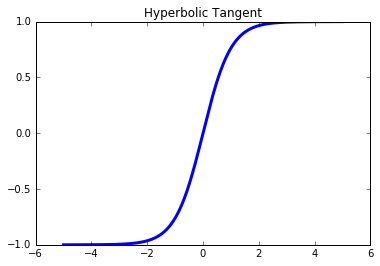

In [194]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump
vals = [i for i in frange(-5,5,.001)]
plt.plot(vals, np.tanh(vals), linewidth=3)
plt.title("Hyperbolic Tangent")
plt.show()

### B. Rectified Linear Unit (Relu)

**a. Function**
* $ relu(z) = max(0, z) $
* Range: $[0, \infty)$

**b. Activation**
* $ relu(0, w\cdot x + b) $

**c. Benefit**
* (Mysteriously) performs better in image recognition tasks (there hasn't been solid investigations into why, although, note that $relu$ stops learning on negative weighted input, which may avoid learning satuaration ($\sigma$ and $tanh$ keep learning on negative weighted input)).

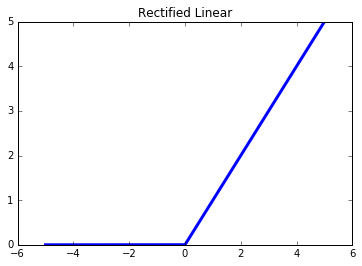

In [195]:
from functools import partial
def relu(z): return map(partial(max, 0), z) if isinstance(z,list) else max(0,z)
plt.plot(vals, relu(vals), linewidth=3)
plt.title("Rectified Linear")
plt.show()

# Universality of NN

### A. "Universal" in what sense?

* **a. NN provides an approximation, not an exact modeling.**
* **b. NN approximates with continuous functions.**

### B. Visualization of NN fitting a one-input function

**Function approximated:**

$ f(x) = 0.2 + 0.4x^2 + 0.3x sin(15x) + 0.05 cos(50x) $

NN APPROXIMATION:


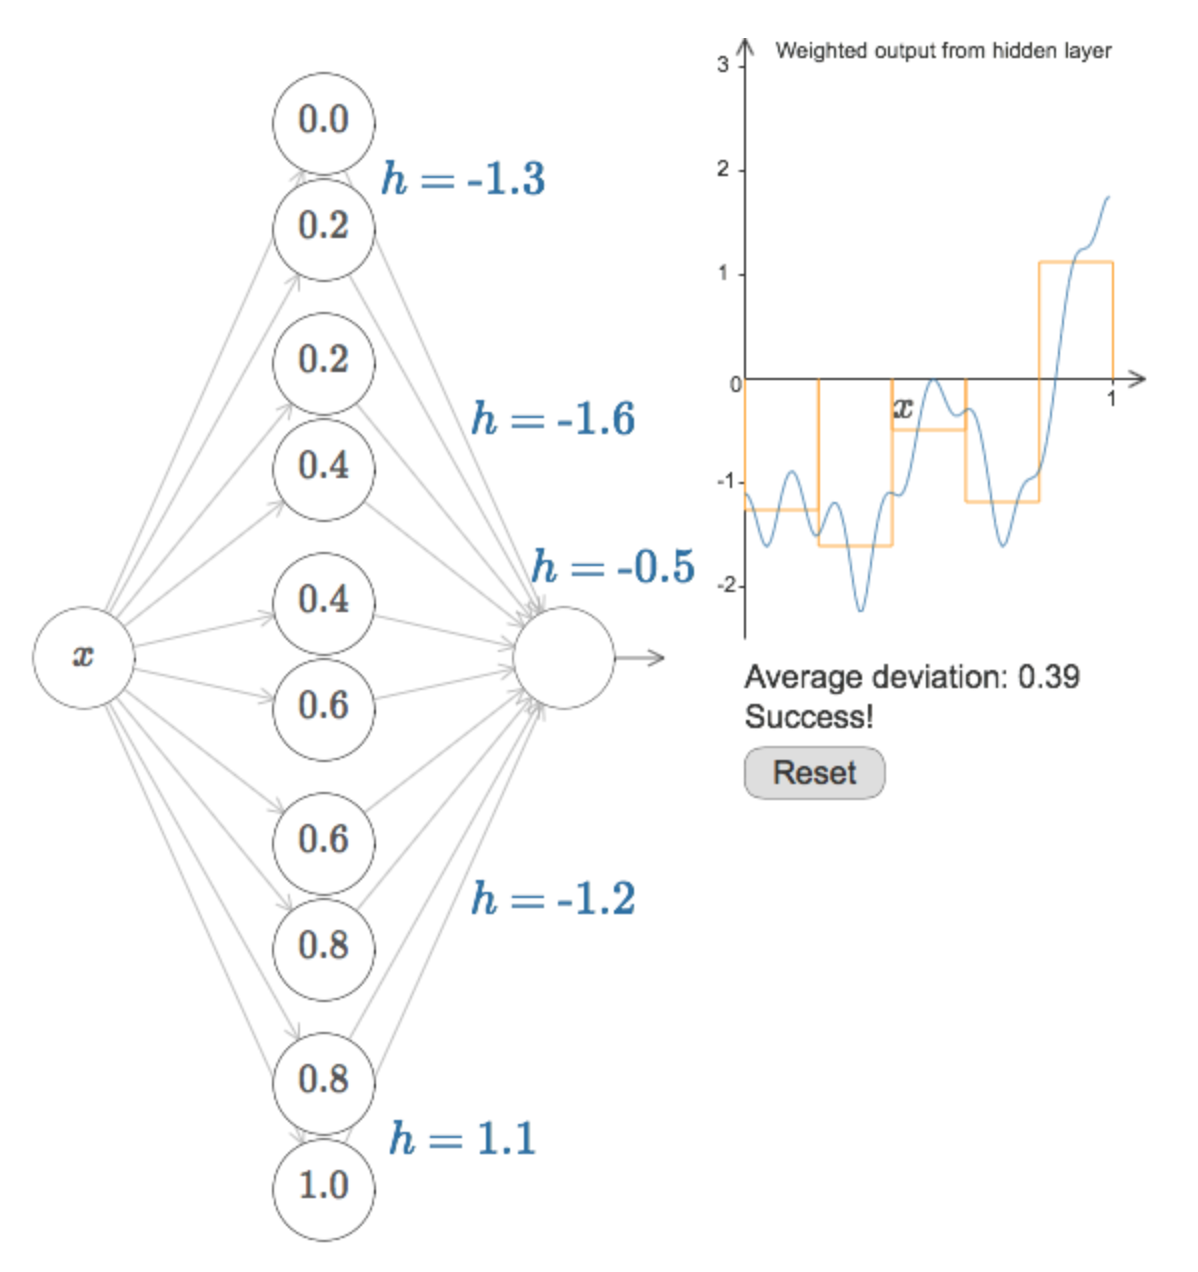

In [201]:
print "NN APPROXIMATION:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/nn_universality_one_input.png", width="35%"))

# Deep Learning

### A. The Main Benefit

* **Provides levels of abstraction, which captures the patterns in leanring tasks better.**
* **Large number of parameters, thus flexible enough to learn almost any pattern.**

### B. Difficulties in Deep Learning: Unstable Gradient

#### a. Vanishing Gradient Problem (gradient update < 1, i.e. $ \frac{\partial \sigma(z_j)}{\partial w_j} = w_j\sigma'(z_j) < 1$)

**Visualization**

DISTRIBUTION OF DERIV. OF SIGMOID:


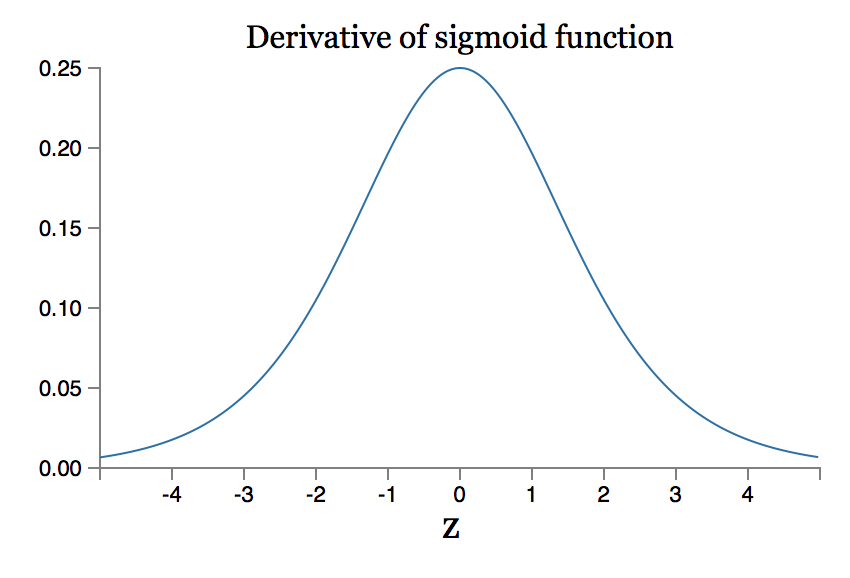

VANISHING GRADIENT:


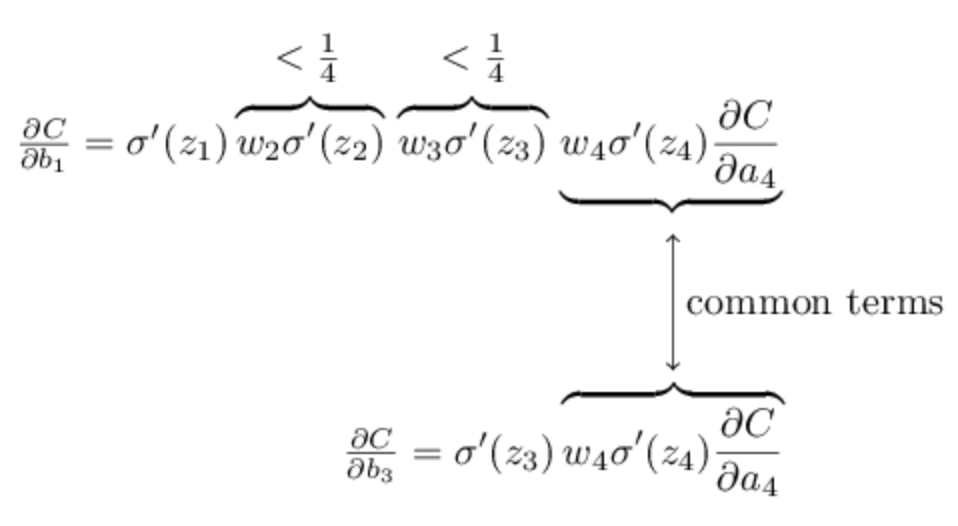

In [203]:
print "DISTRIBUTION OF DERIV. OF SIGMOID:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/vanishing_gradient_distribution_of_sigmoid_derivative.png", width="35%"))
print "VANISHING GRADIENT:"
display(Image(filename="/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NN/FIGS/vanishing_gradient_equation.png", width="35%"))

#### B. Exploding Gradient Problem (gradient update > 1, i.e. $ \frac{\partial \sigma(z_j)}{\partial w_j}  =w_j\sigma'(z_j) > 1$)